In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torch.optim as optim
import pytorch_lightning as pl
import copy
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import torchmetrics
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")
print(device)

cuda:0


# General ML Algorithms

In [3]:
classes=['Covid','No Covid']

In [4]:
num_classes=2
batch_size=4

In [5]:
dataset = torchvision.datasets.ImageFolder(root="./data",transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Resize([227,227]),
#                                                             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                                            ]))

In [6]:
print(len(dataset))
trainset,testset=torch.utils.data.random_split(dataset,[round(0.8*len(dataset)),round(0.2*len(dataset))],generator=torch.Generator().manual_seed(42))
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

8088


In [7]:
def plot_img(img,normal=False):
    npimg=img.numpy()
    if normal:
#     img*mean(0.5) + SD(0.5) => unnormalizing the image
        npimg=img.numpy()/2+0.5
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

In [8]:
%%notify -m "completed"
dataiter=iter(trainloader)
images,labels=dataiter.next()

<IPython.core.display.Javascript object>

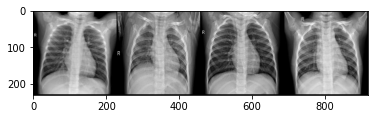

(None, ['No Covid', 'No Covid', 'No Covid', 'No Covid'])

In [9]:
plot_img(torchvision.utils.make_grid(images)),list(map(lambda a: classes[a],labels))

## Extracting the Fully Connected Layer

In [10]:
class VGG(pl.LightningModule):
    def get_first_FC_Layer(self,x):
        x=self.feature_extractor(x).flatten(1)
        x=self.classifier[0](x)
        return x;
    def get_Representation_Net(self,x):
        x=self.feature_extractor(x).flatten(1)
        return  x;
#     def train_dataloader(self):
#         return torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
#     def test_dataloader(self):
#         return torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)
#     def configure_optimizers(self):
#         optimizer = optim.Adam(params=self.parameters(),lr=(self.lr or self.learning_rate))
#         return optimizer
    def __init__(self,learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        # init a pretrained vggnet
        backbone = models.vgg16_bn(pretrained=True)
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        fc=[]
        fc.extend([nn.Linear(in_features=25088,out_features=512),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=512,out_features=128),
           nn.ReLU(),
           nn.Dropout(),
           nn.Linear(in_features=128,out_features=1)
          ])
        self.classifier=nn.Sequential(*fc)
        for param in self.feature_extractor.parameters():
            param.requires_grad=False
#     def forward(self, x):
#         with torch.no_grad():
#             representations = self.feature_extractor(x).flatten(1)
#         x=self.classifier(representations)
#         return x;
#     def training_step(self, batch, batch_idx):
#         inputs, labels = batch
#         pred = self.forward(inputs)
#         labels = labels.unsqueeze(-1)
# #         self.log('train_acc_step', torchmetrics.functional.accuracy(pred, labels,average='micro', mdmc_average='global', num_classes=num_classes, multiclass=False),on_step=True)
# #         self.log('conf matrix',torchmetrics.functional.confusion_matrix(pred,labels,num_classes=num_classes, normalize=None, threshold=0.5, multilabel=False),on_step=True,)
#         labels = labels.type_as(pred)
# #         print(labels)
#         loss = nn.BCEWithLogitsLoss()(pred,labels)
#         self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=False)
        
#         return loss     

In [11]:
vgg=VGG()
# Loading weights
vgg.load_state_dict(torch.load("VGG-final.pth").state_dict())
# print(vgg.get_first_FC_Layer(images).shape)

<All keys matched successfully>

In [12]:
print(vgg.get_first_FC_Layer(images).shape)

torch.Size([4, 512])


### Getting The Fully connected layer

In [13]:
%%notify -m "Completed"

X_Train=np.empty((0,512))
Y_Train=np.empty((0,batch_size))
print(X_Train.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=vgg.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train=np.append(X_Train,FCLayer,axis=0)
    Y_Train=np.append(Y_Train,labels.numpy())
print(X_Train.shape,Y_Train.shape)

(0, 512)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [14]:
%%notify -m "Completed"
X_Test=np.empty((0,512))
Y_Test=np.empty((0,batch_size))
print(X_Test.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    FCLayer=vgg.get_first_FC_Layer(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test=np.append(X_Test,FCLayer,axis=0)
    Y_Test=np.append(Y_Test,labels.numpy())
print(X_Test.shape,Y_Test.shape)

(0, 512)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the bat

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

### Getting the feature extraction layer

In [15]:
%%notify -m "Completed"
X_Train_FeatureMap=np.empty((0,25088))
Y_Train_FeatureMap=np.empty((0,batch_size))
print(X_Train_FeatureMap.shape)
for i,data in enumerate(trainloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featureMap=vgg.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Train_FeatureMap=np.append(X_Train_FeatureMap,featureMap,axis=0)
    Y_Train_FeatureMap=np.append(Y_Train_FeatureMap,labels.numpy())
print(X_Train_FeatureMap.shape,Y_Train_FeatureMap.shape)

(0, 25088)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the b

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


Done with the batch: 660
Done with the batch: 661
Done with the batch: 662
Done with the batch: 663
Done with the batch: 664
Done with the batch: 665
Done with the batch: 666
Done with the batch: 667
Done with the batch: 668
Done with the batch: 669
Done with the batch: 670
Done with the batch: 671
Done with the batch: 672
Done with the batch: 673
Done with the batch: 674
Done with the batch: 675
Done with the batch: 676
Done with the batch: 677
Done with the batch: 678
Done with the batch: 679
Done with the batch: 680
Done with the batch: 681
Done with the batch: 682
Done with the batch: 683
Done with the batch: 684
Done with the batch: 685
Done with the batch: 686
Done with the batch: 687
Done with the batch: 688
Done with the batch: 689
Done with the batch: 690
Done with the batch: 691
Done with the batch: 692
Done with the batch: 693
Done with the batch: 694
Done with the batch: 695
Done with the batch: 696
Done with the batch: 697
Done with the batch: 698
Done with the batch: 699


Done with the batch: 988
Done with the batch: 989
Done with the batch: 990
Done with the batch: 991
Done with the batch: 992
Done with the batch: 993
Done with the batch: 994
Done with the batch: 995
Done with the batch: 996
Done with the batch: 997
Done with the batch: 998
Done with the batch: 999
Done with the batch: 1000
Done with the batch: 1001
Done with the batch: 1002
Done with the batch: 1003
Done with the batch: 1004
Done with the batch: 1005
Done with the batch: 1006
Done with the batch: 1007
Done with the batch: 1008
Done with the batch: 1009
Done with the batch: 1010
Done with the batch: 1011
Done with the batch: 1012
Done with the batch: 1013
Done with the batch: 1014
Done with the batch: 1015
Done with the batch: 1016
Done with the batch: 1017
Done with the batch: 1018
Done with the batch: 1019
Done with the batch: 1020
Done with the batch: 1021
Done with the batch: 1022
Done with the batch: 1023
Done with the batch: 1024
Done with the batch: 1025
Done with the batch: 102

Done with the batch: 1304
Done with the batch: 1305
Done with the batch: 1306
Done with the batch: 1307
Done with the batch: 1308
Done with the batch: 1309
Done with the batch: 1310
Done with the batch: 1311
Done with the batch: 1312
Done with the batch: 1313
Done with the batch: 1314
Done with the batch: 1315
Done with the batch: 1316
Done with the batch: 1317
Done with the batch: 1318
Done with the batch: 1319
Done with the batch: 1320
Done with the batch: 1321
Done with the batch: 1322
Done with the batch: 1323
Done with the batch: 1324
Done with the batch: 1325
Done with the batch: 1326
Done with the batch: 1327
Done with the batch: 1328
Done with the batch: 1329
Done with the batch: 1330
Done with the batch: 1331
Done with the batch: 1332
Done with the batch: 1333
Done with the batch: 1334
Done with the batch: 1335
Done with the batch: 1336
Done with the batch: 1337
Done with the batch: 1338
Done with the batch: 1339
Done with the batch: 1340
Done with the batch: 1341
Done with th

<IPython.core.display.Javascript object>

In [16]:
%%notify -m "Completed"
X_Test_FeatureMap=np.empty((0,25088))
Y_Test_FeatureMap=np.empty((0,batch_size))
print(X_Test_FeatureMap.shape)
for i,data in enumerate(testloader):
    print(f'Done with the batch: {i}')
    images,labels=data
    featuremap=vgg.get_Representation_Net(images).detach().numpy();
#     print(FCLayer,FCLayer.shape,labels.numpy())
    X_Test_FeatureMap=np.append(X_Test_FeatureMap,featuremap,axis=0)
    Y_Test_FeatureMap=np.append(Y_Test_FeatureMap,labels.numpy())
print(X_Test_FeatureMap.shape,Y_Test_FeatureMap.shape)

(0, 25088)
Done with the batch: 0
Done with the batch: 1
Done with the batch: 2
Done with the batch: 3
Done with the batch: 4
Done with the batch: 5
Done with the batch: 6
Done with the batch: 7
Done with the batch: 8
Done with the batch: 9
Done with the batch: 10
Done with the batch: 11
Done with the batch: 12
Done with the batch: 13
Done with the batch: 14
Done with the batch: 15
Done with the batch: 16
Done with the batch: 17
Done with the batch: 18
Done with the batch: 19
Done with the batch: 20
Done with the batch: 21
Done with the batch: 22
Done with the batch: 23
Done with the batch: 24
Done with the batch: 25
Done with the batch: 26
Done with the batch: 27
Done with the batch: 28
Done with the batch: 29
Done with the batch: 30
Done with the batch: 31
Done with the batch: 32
Done with the batch: 33
Done with the batch: 34
Done with the batch: 35
Done with the batch: 36
Done with the batch: 37
Done with the batch: 38
Done with the batch: 39
Done with the batch: 40
Done with the b

Done with the batch: 332
Done with the batch: 333
Done with the batch: 334
Done with the batch: 335
Done with the batch: 336
Done with the batch: 337
Done with the batch: 338
Done with the batch: 339
Done with the batch: 340
Done with the batch: 341
Done with the batch: 342
Done with the batch: 343
Done with the batch: 344
Done with the batch: 345
Done with the batch: 346
Done with the batch: 347
Done with the batch: 348
Done with the batch: 349
Done with the batch: 350
Done with the batch: 351
Done with the batch: 352
Done with the batch: 353
Done with the batch: 354
Done with the batch: 355
Done with the batch: 356
Done with the batch: 357
Done with the batch: 358
Done with the batch: 359
Done with the batch: 360
Done with the batch: 361
Done with the batch: 362
Done with the batch: 363
Done with the batch: 364
Done with the batch: 365
Done with the batch: 366
Done with the batch: 367
Done with the batch: 368
Done with the batch: 369
Done with the batch: 370
Done with the batch: 371


<IPython.core.display.Javascript object>

In [ ]:
def k_fold_cv(model,dataset,loss_function,k_folds=5,epochs=10):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)): 
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
              dataset, 
              batch_size=batch_size, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
              dataset,
              batch_size=batch_size, sampler=test_subsampler)

        # Init the neural network
        network = model
        reset_weights(network)
        optimizer = optim.Adam(network.parameters())
        # Run the training loop for defined number of epochs
        for epoch in range(0, epochs):

            # Print epoch
            print(f'Starting epoch {epoch+1}')

            # Set current loss value
            current_loss = 0.0

            # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):

                # Get inputs
                inputs, targets = data
                inputs = inputs.to(device)
                targets = targets.to(device)
                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)
                targets = targets.unsqueeze(-1)
                targets = targets.type_as(outputs)
                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()

                # Print statistics
                current_loss += loss.item()
                if i % 500 == 499:
                    print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                    current_loss = 0.0

        # Process is complete.
        print('Training process has finished. Saving the trained model.')
        save_path = f'./CNN3-fold-{fold}.pth'
        torch.save(network, save_path)

        # Evaluation for this fold
        correct, total = 0, 0
        with torch.no_grad():

            # Iterate over the test data and generate predictions
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs,targets=inputs.to(device),targets.to(device)
                # Generate outputs
                outputs = network(inputs)
                m = nn.Sigmoid()
                outputs=m(outputs)
                pred=outputs>=0.5
                pred=pred.flatten()
                # Set total and correct
                total += targets.size(0)
                correct += (pred == targets).sum().item()

            # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
            print('--------------------------------')
            results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

## SVM

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score,recall_score

In [74]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-2,0.1,1,10],
                     'C': [0.001,0.1,1, 10, 100],
}
# tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3],
#                      'C': [0.001],
#                    }
clf = GridSearchCV(
        SVC(), tuned_parameters, scoring= 'accuracy',verbose=10
    )
clf.fit(X_Train, Y_Train.ravel())
# print(clf.best_score_)
# print(clf.best_estimator_.get_params())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 1/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.501 total time=  13.9s
[CV 2/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 2/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  13.6s
[CV 3/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 3/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  12.9s
[CV 4/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 4/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  12.8s
[CV 5/5; 1/25] START C=0.001, gamma=0.001, kernel=rbf...........................
[CV 5/5; 1/25] END C=0.001, gamma=0.001, kernel=rbf;, score=0.502 total time=  12.9s
[CV 1/5; 2/25] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 1/5; 2/25] END C=0.001,

[CV 1/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.631 total time=  13.2s
[CV 2/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 2/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.648 total time=  13.0s
[CV 3/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 3/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.665 total time=  13.0s
[CV 4/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 4/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.655 total time=  13.0s
[CV 5/5; 11/25] START C=1, gamma=0.001, kernel=rbf..............................
[CV 5/5; 11/25] END C=1, gamma=0.001, kernel=rbf;, score=0.662 total time=  12.9s
[CV 1/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 1/5; 12/25] END C=1, gamma=0.01, kernel=rbf;, score=0.501 total time=  14.1s
[CV 2/5; 12/25] START C=1, gamma=0.01, kernel=rbf...............................
[CV 2/5; 12/25] END C=1

[CV 2/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.664 total time=  12.7s
[CV 3/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 3/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.675 total time=  12.8s
[CV 4/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 4/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.671 total time=  13.0s
[CV 5/5; 21/25] START C=100, gamma=0.001, kernel=rbf............................
[CV 5/5; 21/25] END C=100, gamma=0.001, kernel=rbf;, score=0.679 total time=  13.2s
[CV 1/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 1/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.501 total time=  14.4s
[CV 2/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 2/5; 22/25] END C=100, gamma=0.01, kernel=rbf;, score=0.502 total time=  14.5s
[CV 3/5; 22/25] START C=100, gamma=0.01, kernel=rbf.............................
[CV 3/5; 22/

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=10)

In [43]:
def k_fold_cv_svm(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
#         clf=SVC(C=10,kernel='rbf',gamma=0.0001)
        clf=SVC(C=10,kernel='rbf',gamma=10)
        clf.fit(X_train,y_train.ravel())
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [25]:
from sklearn.model_selection import KFold

In [26]:
clf=k_fold_cv_svm(X_Train,Y_Train.ravel())
clf=SVC(C=10,kernel='rbf',gamma=0.0001)
clf.fit(X_Train,Y_Train.ravel())
y_pred = clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 97.2952086553323
FOLD 1
--------------------------------
Accuracy: 97.75888717156104
FOLD 2
--------------------------------
Accuracy: 95.90417310664606
FOLD 3
--------------------------------
Accuracy: 97.06336939721793
FOLD 4
--------------------------------
Accuracy: 96.90880989180835
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 97.2952086553323 %
Fold 1: 97.75888717156104 %
Fold 2: 95.90417310664606 %
Fold 3: 97.06336939721793 %
Fold 4: 96.90880989180835 %
Average: 96.98608964451313 %
Accuracy:  0.9610630407911002
F1-Score:  0.9617950272892662
Precision:  0.9542719614921781
Recall:  0.969437652811736
AUC:  0.9609688264058679


## Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
def k_fold_cv_dtree(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        decision_tree = DecisionTreeClassifier(random_state=102)
        decision_tree = decision_tree.fit(X_train, y_train.ravel())
        y_pred = decision_tree.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del decision_tree
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return decision_tree

In [47]:
print(Y_Train.shape,Y_Test.shape)

(6470,) (1618,)


In [30]:
dtree=k_fold_cv_dtree(X_Train,Y_Train.ravel())
dtree = DecisionTreeClassifier(random_state=102)
dtree = dtree.fit(X_Train, Y_Train.ravel())
y_pred=dtree.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 94.97681607418856
FOLD 1
--------------------------------
Accuracy: 95.05409582689336
FOLD 2
--------------------------------
Accuracy: 94.66769706336939
FOLD 3
--------------------------------
Accuracy: 95.98145285935085
FOLD 4
--------------------------------
Accuracy: 94.74497681607419
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 94.97681607418856 %
Fold 1: 95.05409582689336 %
Fold 2: 94.66769706336939 %
Fold 3: 95.98145285935085 %
Fold 4: 94.74497681607419 %
Average: 95.08500772797527 %
Accuracy:  0.9326328800988876
F1-Score:  0.9342977697408077
Precision:  0.9215219976218787
Recall:  0.9474327628361858
AUC:  0.9324663814180929


## RandomForest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
def k_fold_cv_rforest(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
        random_forest = random_forest.fit(X_train, y_train.ravel())
        y_pred = random_forest.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del random_forest
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return random_forest

In [33]:
random_forest=k_fold_cv_rforest(X_Train,Y_Train.ravel())
random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
random_forest = random_forest.fit(X_Train, Y_Train.ravel())
y_pred=random_forest.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 96.67697063369397
FOLD 1
--------------------------------
Accuracy: 96.83153013910355
FOLD 2
--------------------------------
Accuracy: 97.3724884080371
FOLD 3
--------------------------------
Accuracy: 97.14064914992272
FOLD 4
--------------------------------
Accuracy: 97.83616692426584
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 96.67697063369397 %
Fold 1: 96.83153013910355 %
Fold 2: 97.3724884080371 %
Fold 3: 97.14064914992272 %
Fold 4: 97.83616692426584 %
Average: 97.17156105100464 %
Accuracy:  0.9598269468479604
F1-Score:  0.960582171012735
Precision:  0.9530685920577617
Recall:  0.9682151589242054
AUC:  0.9597325794621028


In [31]:
%%notify -m "Completed"
# With subsampling the features and bootstrapping in random forest we get
for i in [1,10,100,200,500]:
    for crit in ["gini","entropy"]:
        random_forest = RandomForestClassifier(n_estimators=i,random_state=102,criterion=crit)
        random_forest=random_forest.fit(X_Train,Y_Train.ravel())
        y_pred=random_forest.predict(X_Test)
        print(f"Accuracy with criterion {crit} and {i} trees/estimators: ",accuracy_score(Y_Test,y_pred))

Accuracy with criterion gini and 1 trees/estimators:  0.9320148331273177
Accuracy with criterion entropy and 1 trees/estimators:  0.9276885043263288
Accuracy with criterion gini and 10 trees/estimators:  0.9567367119901112
Accuracy with criterion entropy and 10 trees/estimators:  0.9585908529048207
Accuracy with criterion gini and 100 trees/estimators:  0.9610630407911002
Accuracy with criterion entropy and 100 trees/estimators:  0.9610630407911002
Accuracy with criterion gini and 200 trees/estimators:  0.9610630407911002
Accuracy with criterion entropy and 200 trees/estimators:  0.9604449938195303
Accuracy with criterion gini and 500 trees/estimators:  0.9604449938195303
Accuracy with criterion entropy and 500 trees/estimators:  0.9616810877626699


<IPython.core.display.Javascript object>

In [167]:
%%notify -m "Completed"
# With taking whole features and no bootstrapping in random forest we get (i.e) all classifiers are a single decision tree
for i in [1,10,100,200,500]:
    for crit in ["gini","entropy"]:
        random_forest = RandomForestClassifier(n_estimators=i,random_state=102,criterion=crit,bootstrap=False,max_features=None)
        random_forest=random_forest.fit(X_Train,Y_Train.ravel())
        y_pred=random_forest.predict(X_Test)
        print(f"Accuracy with criterion {crit} and {i} trees/estimators: ",accuracy_score(Y_Test,y_pred))

Accuracy with criterion gini and 1 trees/estimators:  0.9487021013597033
Accuracy with criterion entropy and 1 trees/estimators:  0.9499381953028431
Accuracy with criterion gini and 10 trees/estimators:  0.953646477132262
Accuracy with criterion entropy and 10 trees/estimators:  0.9511742892459827
Accuracy with criterion gini and 100 trees/estimators:  0.9555006180469716
Accuracy with criterion entropy and 100 trees/estimators:  0.9480840543881335
Accuracy with criterion gini and 200 trees/estimators:  0.9542645241038319
Accuracy with criterion entropy and 200 trees/estimators:  0.946229913473424
Accuracy with criterion gini and 500 trees/estimators:  0.9548825710754018
Accuracy with criterion entropy and 500 trees/estimators:  0.946229913473424


<IPython.core.display.Javascript object>

## XGBOOST

In [34]:
import xgboost as xgb

In [35]:
def k_fold_cv_xgb(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        eval_set = [(X_train, y_train.ravel()), (X_test, y_test)]
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
        xg_cl.fit(X_train,y_train.ravel())
        y_pred = xg_cl.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del xg_cl
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return xg_cl

In [36]:
xg=k_fold_cv_xgb(X_Train,Y_Train.ravel())
xg = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
xg.fit(X_Train,Y_Train.ravel())
y_pred=xg.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
[23:53:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 97.3724884080371
FOLD 1
--------------------------------
[23:54:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 97.99072642967542
FOLD 2
--------------------------------
[23:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

## MLP

In [37]:
from sklearn.neural_network import MLPClassifier

In [38]:
def k_fold_cv_mlp(X,Y,k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    # Initialize optimizer
    results = {}
    for fold, (train_ids, test_ids) in enumerate(kfold.split(X)): 
        print(f'FOLD {fold}')
        print('--------------------------------')
        X_train, X_test = X[train_ids], X[test_ids]
        y_train, y_test = Y[train_ids], Y[test_ids]
        clf = MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results[fold] = 100.0 * accuracy_score(y_test, y_pred)
        print("Accuracy:",results[fold])
        if fold != k_folds-1:
            # The last model used for testing accuracy
            del clf
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')
    return clf

In [39]:
clf=k_fold_cv_mlp(X_Train,Y_Train.ravel())
clf=MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_Train, Y_Train.ravel())
y_pred=clf.predict(X_Test)
print("Accuracy: ",accuracy_score(Y_Test.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test.ravel(),y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 2.26143490
Iteration 2, loss = 0.58412682
Iteration 3, loss = 0.38872076
Iteration 4, loss = 0.27695517
Iteration 5, loss = 0.22505846
Iteration 6, loss = 0.28284174
Iteration 7, loss = 0.24412891
Iteration 8, loss = 0.17698757
Iteration 9, loss = 0.27256135
Iteration 10, loss = 0.27535134
Iteration 11, loss = 0.25920197
Iteration 12, loss = 0.19432195
Iteration 13, loss = 0.14354798
Iteration 14, loss = 0.13674576
Iteration 15, loss = 0.10997184
Iteration 16, loss = 0.15044805
Iteration 17, loss = 0.15586096
Iteration 18, loss = 0.13938034
Iteration 19, loss = 0.17435096
Iteration 20, loss = 0.13080709
Iteration 21, loss = 0.12261794
Iteration 22, loss = 0.18835403
Iteration 23, loss = 0.09239147
Iteration 24, loss = 0.10236244
Iteration 25, loss = 0.09492834
Iteration 26, loss = 0.09228966
Iteration 27, loss = 0.11060052
Iteration 28, loss = 0.10841134
Iteration 29, loss = 0.08753741
Iteration 30, loss = 0.12984777
Iteration

Accuracy: 95.5950540958269
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 97.52704791344668 %
Fold 1: 97.06336939721793 %
Fold 2: 95.5950540958269 %
Fold 3: 97.44976816074188 %
Fold 4: 95.5950540958269 %
Average: 96.64605873261205 %
Iteration 1, loss = 2.03614554
Iteration 2, loss = 0.47496226
Iteration 3, loss = 0.30060235
Iteration 4, loss = 0.27346142
Iteration 5, loss = 0.24578009
Iteration 6, loss = 0.17588551
Iteration 7, loss = 0.25892180
Iteration 8, loss = 0.16780370
Iteration 9, loss = 0.15719360
Iteration 10, loss = 0.17284413
Iteration 11, loss = 0.14356606
Iteration 12, loss = 0.24584866
Iteration 13, loss = 0.13810284
Iteration 14, loss = 0.10415210
Iteration 15, loss = 0.15115524
Iteration 16, loss = 0.24345093
Iteration 17, loss = 0.10563536
Iteration 18, loss = 0.12416872
Iteration 19, loss = 0.10712560
Iteration 20, loss = 0.12611728
Iteration 21, loss = 0.12096051
Iteration 22, loss = 0.12700508
Iteration 23, loss = 0.20871900
It

## PCA

In [40]:
from sklearn.decomposition import KernelPCA

Text(0, 0.5, 'cumulative explained variance')

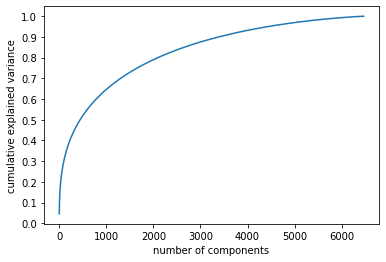

In [16]:
kpca = KernelPCA(kernel = 'rbf')
kpca_transform = kpca.fit_transform(X_Train_FeatureMap)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [41]:
kpca = KernelPCA(kernel = 'rbf',n_components=6000)
X_Train_Transformed_FeatureMap = kpca.fit_transform(X_Train_FeatureMap)
print(X_Train_Transformed_FeatureMap.shape)

(6470, 6000)


In [42]:
X_Test_Transformed_FeatureMap = kpca.transform(X_Test_FeatureMap)

print(X_Test_FeatureMap.shape,X_Test_Transformed_FeatureMap.shape)

(1618, 25088) (1618, 6000)


## SVM (with PCA)

In [44]:
clf=k_fold_cv_svm(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
clf=SVC(C=10,kernel='rbf',gamma=10)
clf.fit(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 95.36321483771252
FOLD 1
--------------------------------
Accuracy: 94.5904173106646
FOLD 2
--------------------------------
Accuracy: 94.82225656877898
FOLD 3
--------------------------------
Accuracy: 96.05873261205564
FOLD 4
--------------------------------
Accuracy: 94.74497681607419
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 95.36321483771252 %
Fold 1: 94.5904173106646 %
Fold 2: 94.82225656877898 %
Fold 3: 96.05873261205564 %
Fold 4: 94.74497681607419 %
Average: 95.11591962905719 %
Accuracy:  0.9456118665018541
F1-Score:  0.9469240048250905
Precision:  0.9345238095238095
Recall:  0.9596577017114915
AUC:  0.9454538508557457


## Decision Tree (with PCA)

In [45]:
dtree=k_fold_cv_dtree(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
dtree = DecisionTreeClassifier(random_state=102)
dtree = dtree.fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())
y_pred=dtree.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 80.52550231839258
FOLD 1
--------------------------------
Accuracy: 78.516228748068
FOLD 2
--------------------------------
Accuracy: 79.36630602782071
FOLD 3
--------------------------------
Accuracy: 78.97990726429676
FOLD 4
--------------------------------
Accuracy: 81.06646058732612
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 80.52550231839258 %
Fold 1: 78.516228748068 %
Fold 2: 79.36630602782071 %
Fold 3: 78.97990726429676 %
Fold 4: 81.06646058732612 %
Average: 79.69088098918084 %
Accuracy:  0.8220024721878862
F1-Score:  0.8275449101796407
Precision:  0.8110328638497653
Recall:  0.8447432762836186
AUC:  0.8217466381418093


## Random Forest (with PCA)

In [47]:
random_forest=k_fold_cv_rforest(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=102)
random_forest = random_forest.fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())
y_pred=random_forest.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Accuracy: 80.98918083462134
FOLD 1
--------------------------------
Accuracy: 78.5935085007728
FOLD 2
--------------------------------
Accuracy: 76.97063369397218
FOLD 3
--------------------------------
Accuracy: 79.05718701700154
FOLD 4
--------------------------------
Accuracy: 74.42040185471407
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 80.98918083462134 %
Fold 1: 78.5935085007728 %
Fold 2: 76.97063369397218 %
Fold 3: 79.05718701700154 %
Fold 4: 74.42040185471407 %
Average: 78.00618238021639 %
Accuracy:  0.7991347342398022
F1-Score:  0.7750865051903114
Precision:  0.8931419457735247
Recall:  0.684596577017115
AUC:  0.8004232885085575


## XGBOOST

In [46]:
xg=k_fold_cv_xgb(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
xg = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=102,use_label_encoder=False)
xg.fit(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
y_pred=xg.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
[00:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 91.88562596599691
FOLD 1
--------------------------------
[00:21:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 92.8129829984544
FOLD 2
--------------------------------
[00:24:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was 

## MLP

In [48]:
clf=k_fold_cv_mlp(X_Train_Transformed_FeatureMap,Y_Train_FeatureMap.ravel())
clf=MLPClassifier(random_state=102, max_iter=3000, verbose=True).fit(X_Train_Transformed_FeatureMap, Y_Train_FeatureMap.ravel())
y_pred=clf.predict(X_Test_Transformed_FeatureMap)
print("Accuracy: ",accuracy_score(Y_Test_FeatureMap.ravel(),y_pred))
print("F1-Score: ",f1_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Precision: ",precision_score(Y_Test_FeatureMap.ravel(),y_pred))
print("Recall: ",recall_score(Y_Test_FeatureMap.ravel(),y_pred))
print("AUC: ",roc_auc_score(Y_Test_FeatureMap.ravel(),y_pred))

FOLD 0
--------------------------------
Iteration 1, loss = 0.69083233
Iteration 2, loss = 0.66542371
Iteration 3, loss = 0.62130651
Iteration 4, loss = 0.55766791
Iteration 5, loss = 0.48433600
Iteration 6, loss = 0.40783375
Iteration 7, loss = 0.33738868
Iteration 8, loss = 0.27664467
Iteration 9, loss = 0.22630096
Iteration 10, loss = 0.18544501
Iteration 11, loss = 0.15314036
Iteration 12, loss = 0.12756556
Iteration 13, loss = 0.10721567
Iteration 14, loss = 0.09100723
Iteration 15, loss = 0.07791644
Iteration 16, loss = 0.06730575
Iteration 17, loss = 0.05862480
Iteration 18, loss = 0.05143372
Iteration 19, loss = 0.04545278
Iteration 20, loss = 0.04040932
Iteration 21, loss = 0.03621829
Iteration 22, loss = 0.03265539
Iteration 23, loss = 0.02955417
Iteration 24, loss = 0.02687821
Iteration 25, loss = 0.02455805
Iteration 26, loss = 0.02256060
Iteration 27, loss = 0.02081248
Iteration 28, loss = 0.01924690
Iteration 29, loss = 0.01788823
Iteration 30, loss = 0.01666439
Iteration

Iteration 24, loss = 0.02829617
Iteration 25, loss = 0.02585252
Iteration 26, loss = 0.02371240
Iteration 27, loss = 0.02185942
Iteration 28, loss = 0.02022221
Iteration 29, loss = 0.01874166
Iteration 30, loss = 0.01744449
Iteration 31, loss = 0.01627817
Iteration 32, loss = 0.01527856
Iteration 33, loss = 0.01434292
Iteration 34, loss = 0.01349751
Iteration 35, loss = 0.01273556
Iteration 36, loss = 0.01203765
Iteration 37, loss = 0.01141858
Iteration 38, loss = 0.01085401
Iteration 39, loss = 0.01031604
Iteration 40, loss = 0.00984901
Iteration 41, loss = 0.00942504
Iteration 42, loss = 0.00899827
Iteration 43, loss = 0.00864653
Iteration 44, loss = 0.00830396
Iteration 45, loss = 0.00797736
Iteration 46, loss = 0.00767947
Iteration 47, loss = 0.00740282
Iteration 48, loss = 0.00713648
Iteration 49, loss = 0.00690320
Iteration 50, loss = 0.00667942
Iteration 51, loss = 0.00648062
Iteration 52, loss = 0.00628483
Iteration 53, loss = 0.00610331
Iteration 54, loss = 0.00593351
Iteratio